# Import Libraries & Load Data

In [66]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
DATA_DIR = "./data"
EXERCISE_PATH = os.path.join(DATA_DIR, "exercise.csv")
CALORIES_PATH = os.path.join(DATA_DIR, "calories.csv")

print("Dataset Paths")
print("Exercise CSV path:", EXERCISE_PATH)
print("Calories CSV path:", CALORIES_PATH)

exercise = pd.read_csv(EXERCISE_PATH)
calories = pd.read_csv(CALORIES_PATH)

print("\nDataset Dimensions")
print("Exercise Shape:", exercise.shape)
print("Calories Shape:", calories.shape)

print("\n \nDataset First 5 rows!")
display(exercise.head())
display(calories.head())

Dataset Paths
Exercise CSV path: ./data/exercise.csv
Calories CSV path: ./data/calories.csv

Dataset Dimensions
Exercise Shape: (15000, 8)
Calories Shape: (15000, 2)

 
Dataset First 5 rows!


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


# Data Preprocessing & Create DataFrame

In [67]:
# Merge on User_ID
df = pd.merge(exercise, calories, on="User_ID", how="inner")
print("Merged shape:", df.shape)

# Clean column names
df.columns = [col.strip().replace(" ", "_") for col in df.columns]

# Key numeric columns
numeric_cols = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "Calories"]

for col in numeric_cols: df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing key info
df = df.dropna(subset=numeric_cols + ["Gender"]).reset_index(drop=True)

# Normalize gender text and encode: male -> 1, female -> 0
df["Gender"] = df["Gender"].str.lower().str.strip()
gender_map = {"male": 1, "female": 0}
df["Gender"] = df["Gender"].map(gender_map)

# BMI feature: kg / m^2
df["BMI"] = (df["Weight"] / ((df["Height"]/100) ** 2)).round(2)

# Final feature set and target
feature_cols = ["Gender", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "BMI"]
target_col = "Calories"

print("Final columns used for modeling:")
print("Features:", feature_cols)
print("Target  :", target_col)
display(df.head())

Merged shape: (15000, 9)
Final columns used for modeling:
Features: ['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI']
Target  : Calories


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,231.0,26.04
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,66.0,21.77
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,26.0,24.66
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,71.0,22.16
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,35.0,24.46


# Exploratory Data Analysis

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")
print("\nBasic Info")
print(df.info())

print("\nStatistics Summary")
stats_summary = df[numeric_cols + ["BMI"]].describe()
display(stats_summary)


Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  int64  
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
 9   BMI         15000 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 1.1 MB
None

Statistics Summary


,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533,24.345013
std,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978,1.558692
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000,19.230000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000,23.240000
50%,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000,24.380000
75%,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000,25.490000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000,29.070000


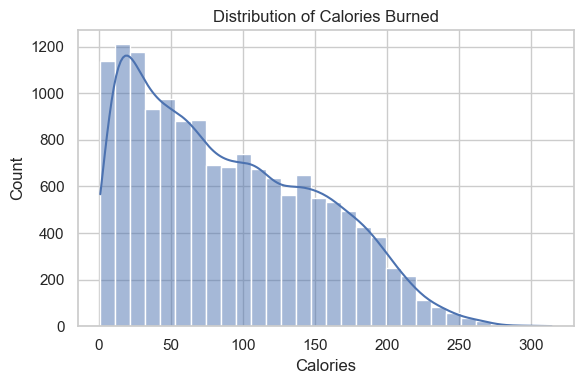


[EDA 1 – Distribution of Calories]
Observation: Calories burned per session has mean 89.5 and median 79.0. Most values lie between 35.0 and 138.0, with a long right tail up to about 314.0 calories (skew ≈ 0.51).
Possible reason: The dataset contains many short-to-moderate workouts and only a smaller number of very long or very intense sessions, which naturally produce the extreme high-calorie values.
Use for RQs: The target (Calories) is right-skewed, so models that assume a perfectly Gaussian target may not be ideal. This motivates using flexible models (e.g., tree-based / monotone GBDT) or considering transformations, and focusing evaluation on the dense low–to–mid calorie range where most users lie.


In [69]:
# [EDA 1 – Distribution of Calories]
plt.figure(figsize=(6, 4))
sns.histplot(df["Calories"], kde=True, bins=30)
plt.title("Distribution of Calories Burned")
plt.xlabel("Calories")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

cal_stats = df["Calories"].describe()
cal_skew = df["Calories"].skew()

print("\n[EDA 1 – Distribution of Calories]")
print(
    f"Observation: Calories burned per session has mean {cal_stats['mean']:.1f} and "
    f"median {cal_stats['50%']:.1f}. Most values lie between "
    f"{cal_stats['25%']:.1f} and {cal_stats['75%']:.1f}, with a long right tail "
    f"up to about {cal_stats['max']:.1f} calories (skew ≈ {cal_skew:.2f}).")
print(
    "Possible reason: The dataset contains many short-to-moderate workouts and only a "
    "smaller number of very long or very intense sessions, which naturally produce "
    "the extreme high-calorie values.")
print(
    "Use for RQs: The target (Calories) is right-skewed, so models that assume a "
    "perfectly Gaussian target may not be ideal. This motivates using flexible "
    "models (e.g., tree-based / monotone GBDT) or considering transformations, "
    "and focusing evaluation on the dense low–to–mid calorie range where most users lie.")

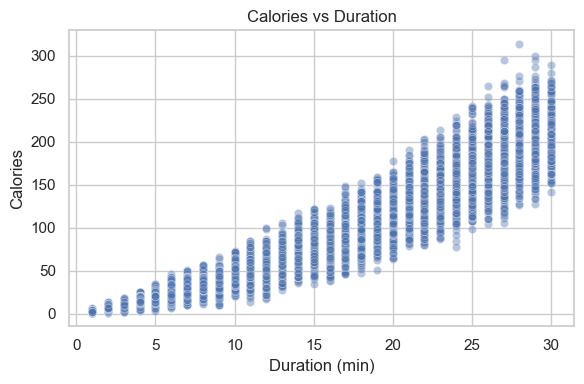


[EDA 2 – Calories vs Duration]
Observation: There is a very strong positive, almost linear relationship between Duration and Calories (corr ≈ 0.96). Longer workouts consistently burn more calories, with only moderate vertical spread at each duration.
Possible reason: Total energy expenditure is roughly proportional to how long a person maintains activity, especially when the exercise type is similar across sessions.
Use for RQs: Duration is a key driver of calories and should be one of the main predictors in our models. We can reasonably enforce a monotonic constraint Duration ↑ ⇒ Calories ↑ in methods like monotone gradient boosting, and we expect any good model answering our prediction-oriented research questions to capture this strong trend.


In [70]:
# [EDA 2 – Calories vs Duration]

plt.figure(figsize=(6, 4))
sns.scatterplot(x="Duration", y="Calories", data=df, alpha=0.4)
plt.title("Calories vs Duration")
plt.xlabel("Duration (min)")
plt.ylabel("Calories")
plt.tight_layout()
plt.show()

dur_corr = df["Duration"].corr(df["Calories"])

print("\n[EDA 2 – Calories vs Duration]")
print(
    f"Observation: There is a very strong positive, almost linear relationship between "
    f"Duration and Calories (corr ≈ {dur_corr:.2f}). Longer workouts consistently burn "
    "more calories, with only moderate vertical spread at each duration.")
print(
    "Possible reason: Total energy expenditure is roughly proportional to how long a "
    "person maintains activity, especially when the exercise type is similar across sessions.")
print(
    "Use for RQs: Duration is a key driver of calories and should be one of the main "
    "predictors in our models. We can reasonably enforce a monotonic constraint "
    "Duration ↑ ⇒ Calories ↑ in methods like monotone gradient boosting, and we "
    "expect any good model answering our prediction-oriented research questions to "
    "capture this strong trend.")

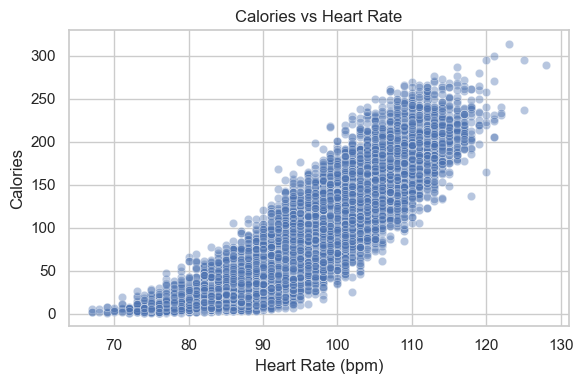


[EDA 3 – Calories vs Heart Rate]
Observation: Calories increase sharply with Heart Rate (corr ≈ 0.90). Sessions with higher average heart rate tend to burn substantially more calories, though there is more spread than with Duration.
Possible reason: Heart rate is a proxy for exercise intensity. Even for the same duration, more intense workouts (higher HR) consume more energy.
Use for RQs: Heart rate complements Duration by capturing intensity. Including both Duration and Heart_Rate allows our models to distinguish between a long easy session and a shorter high-intensity one, which is important for accurate calorie prediction and any analysis comparing workout strategies.


In [71]:
# [EDA 3 – Calories vs Heart Rate]

plt.figure(figsize=(6, 4))
sns.scatterplot(x="Heart_Rate", y="Calories", data=df, alpha=0.4)
plt.title("Calories vs Heart Rate")
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Calories")
plt.tight_layout()
plt.show()

hr_corr = df["Heart_Rate"].corr(df["Calories"])

print("\n[EDA 3 – Calories vs Heart Rate]")
print(
    f"Observation: Calories increase sharply with Heart Rate (corr ≈ {hr_corr:.2f}). "
    "Sessions with higher average heart rate tend to burn substantially more calories, "
    "though there is more spread than with Duration.")
print(
    "Possible reason: Heart rate is a proxy for exercise intensity. Even for the same "
    "duration, more intense workouts (higher HR) consume more energy.")
print(
    "Use for RQs: Heart rate complements Duration by capturing intensity. Including both "
    "Duration and Heart_Rate allows our models to distinguish between a long easy session "
    "and a shorter high-intensity one, which is important for accurate calorie prediction "
    "and any analysis comparing workout strategies.")

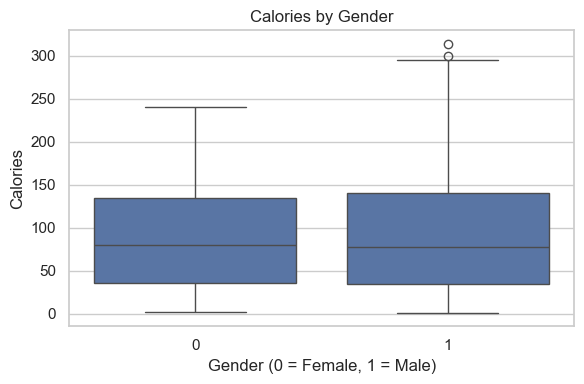


[EDA 4 – Calories by Gender]
Observation: The calorie distributions for males and females are quite similar. On average, males burn about 2.8 more calories than females (male ≈ 90.9, female ≈ 88.2), which is a small effect relative to the overall variability.
Possible reason: Males in the dataset may, on average, have slightly higher body mass or perform marginally more intense/longer workouts, but the exercise protocol appears broadly similar across genders.
Use for RQs: Since the gender effect is modest, Gender may not be a primary driver of calories compared to Duration or Heart_Rate. For prediction-focused questions we might include Gender as a weak feature or omit it to simplify the model. For any fairness-related research question, this block shows that performance differences across genders should be small but worth verifying.


In [72]:
# [EDA 4 – Calories by Gender]

plt.figure(figsize=(6, 4))
sns.boxplot(x="Gender", y="Calories", data=df)
plt.title("Calories by Gender")
plt.xlabel("Gender (0 = Female, 1 = Male)")
plt.ylabel("Calories")
plt.tight_layout()
plt.show()

gender_stats = df.groupby("Gender")["Calories"].mean()
if set([0, 1]).issubset(gender_stats.index):
    female_mean = gender_stats[0]
    male_mean = gender_stats[1]
    diff = male_mean - female_mean
else:
    female_mean = male_mean = diff = np.nan

print("\n[EDA 4 – Calories by Gender]")
print(
    f"Observation: The calorie distributions for males and females are quite similar. "
    f"On average, males burn about {diff:.1f} more calories than females "
    f"(male ≈ {male_mean:.1f}, female ≈ {female_mean:.1f}), which is a small effect "
    "relative to the overall variability.")
print(
    "Possible reason: Males in the dataset may, on average, have slightly higher body "
    "mass or perform marginally more intense/longer workouts, but the exercise protocol "
    "appears broadly similar across genders.")
print(
    "Use for RQs: Since the gender effect is modest, Gender may not be a primary driver "
    "of calories compared to Duration or Heart_Rate. For prediction-focused questions we "
    "might include Gender as a weak feature or omit it to simplify the model. For any "
    "fairness-related research question, this block shows that performance differences "
    "across genders should be small but worth verifying.")

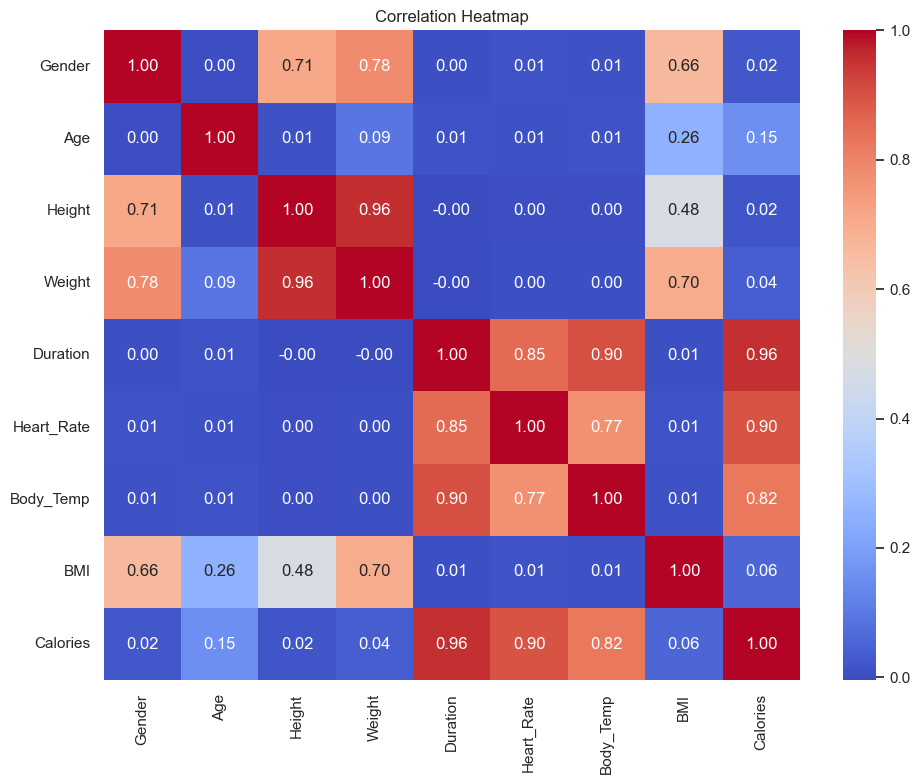


[EDA 5 – Correlation structure]
Observation:
- Strongest positive correlations with Calories are Duration (0.96), Heart_Rate (0.90), and Body_Temp (0.82).
- Weight is also moderately correlated with Calories (0.04), while Age, Gender, Height, and BMI have weak correlations with Calories.
Possible reason: Duration and Heart_Rate directly control total work and intensity; Body_Temp rises with sustained effort, and heavier individuals expend slightly more energy. Age, height, and BMI matter less once actual workout behavior is observed.
Use for RQs: This block guides feature selection and modeling strategy. We know which variables should drive predictions (Duration, Heart_Rate, Body_Temp, Weight) and which are secondary. For linear models (like LASSO), we must watch for multicollinearity (e.g., Height–Weight–BMI are highly correlated). 
For tree/GBDT models, we can prioritize monotonic constraints on the strongly related features and use this structure to interpret variable importance wh

In [73]:
# [EDA 5 – Correlation structure]

corr_cols = feature_cols + [target_col]  # ["Gender", "Age", ..., "BMI"] + ["Calories"]
corr = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

corr_with_cal = corr["Calories"].drop("Calories").sort_values(ascending=False)

print("\n[EDA 5 – Correlation structure]")
print("Observation:")
print(
    f"- Strongest positive correlations with Calories are Duration "
    f"({corr_with_cal['Duration']:.2f}), Heart_Rate ({corr_with_cal['Heart_Rate']:.2f}), "
    f"and Body_Temp ({corr_with_cal['Body_Temp']:.2f}).")
print(
    f"- Weight is also moderately correlated with Calories "
    f"({corr_with_cal['Weight']:.2f}), while Age, Gender, Height, and BMI have weak "
    "correlations with Calories.")
print(
    "Possible reason: Duration and Heart_Rate directly control total work and intensity; "
    "Body_Temp rises with sustained effort, and heavier individuals expend slightly more "
    "energy. Age, height, and BMI matter less once actual workout behavior is observed.")
print(
    "Use for RQs: This block guides feature selection and modeling strategy. We know "
    "which variables should drive predictions (Duration, Heart_Rate, Body_Temp, Weight) "
    "and which are secondary. For linear models (like LASSO), we must watch for "
    "multicollinearity (e.g., Height–Weight–BMI are highly correlated). \nFor tree/GBDT "
    "models, we can prioritize monotonic constraints on the strongly related features and "
    "use this structure to interpret variable importance when answering our research questions.")

# RQ 1: Between LASSO and Monotone GBDT, which generalizes better under 5-fold CV?

In [74]:
X = df[feature_cols].copy()
y = df[target_col].values

# Train / calibration / test split (will be reused later for RQ2 & RQ3)
X_train_full, X_test, y_train_full, y_test, gender_train_full, gender_test, age_train_full, age_test = train_test_split(
    X,
    y,
    df["Gender"],
    df["Age"],
    test_size=0.2,
    random_state=RANDOM_STATE
)

X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.25,  # 0.25 of 0.8 => 0.2 -> 60/20/20 split
    random_state=RANDOM_STATE
)

print("Train shape      :", X_train.shape)
print("Calibration shape:", X_cal.shape)
print("Test shape       :", X_test.shape)

# LASSO pipeline (needs scaling)
lasso_pipeline_cv = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=0.01, max_iter=10000)),
    ]
)

# Monotonic constraints: Duration and Heart_Rate must be non-decreasing
# feature_cols = ["Gender_Code", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "BMI"]
monotonic_cst = [0, 0, 0, 0, 1, 1, 0, 0]

gbdt_mono_cv = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=5,
    learning_rate=0.05,
    max_iter=500,
    monotonic_cst=monotonic_cst,
    random_state=RANDOM_STATE,
)

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lasso_rmse_scores = -cross_val_score(
    estimator=lasso_pipeline_cv,
    X=X,
    y=y,
    scoring="neg_root_mean_squared_error",
    cv=cv,
)

gbdt_rmse_scores = -cross_val_score(
    estimator=gbdt_mono_cv,
    X=X,
    y=y,
    scoring="neg_root_mean_squared_error",
    cv=cv,
)

lasso_r2_scores = cross_val_score(
    estimator=lasso_pipeline_cv,
    X=X,
    y=y,
    scoring="r2",
    cv=cv,
)

gbdt_r2_scores = cross_val_score(
    estimator=gbdt_mono_cv,
    X=X,
    y=y,
    scoring="r2",
    cv=cv,
)

lasso_rmse_mean = float(lasso_rmse_scores.mean())
gbdt_rmse_mean = float(gbdt_rmse_scores.mean())
lasso_r2_mean = float(lasso_r2_scores.mean())
gbdt_r2_mean = float(gbdt_r2_scores.mean())

print("\n=== RQ1: 5-fold CV results ===")
print(f"LASSO RMSE: mean={lasso_rmse_mean:.3f}, std={lasso_rmse_scores.std():.3f}")
print(f"Monotone GBDT RMSE: mean={gbdt_rmse_mean:.3f}, std={gbdt_rmse_scores.std():.3f}")

print(f"LASSO R^2: mean={lasso_r2_mean:.3f}, std={lasso_r2_scores.std():.3f}")
print(f"Monotone GBDT R^2: mean={gbdt_r2_mean:.3f}, std={gbdt_r2_scores.std():.3f}")

Train shape      : (9000, 8)
Calibration shape: (3000, 8)
Test shape       : (3000, 8)

=== RQ1: 5-fold CV results ===
LASSO RMSE: mean=11.033, std=0.168
Monotone GBDT RMSE: mean=2.526, std=0.090
LASSO R^2: mean=0.969, std=0.001
Monotone GBDT R^2: mean=0.998, std=0.000


# RQ 2 : Does Monotone GBDT outperform LASSO while showing non-decreasing Partial Dependence/Individual Conditional Expectation for duration and heart rate?


=== RQ2: Hold-out performance comparison ===
LASSO -> RMSE=11.224, MAE=8.193, R^2=0.969
Monotone GBDT -> RMSE=2.362, MAE=1.660, R^2=0.999


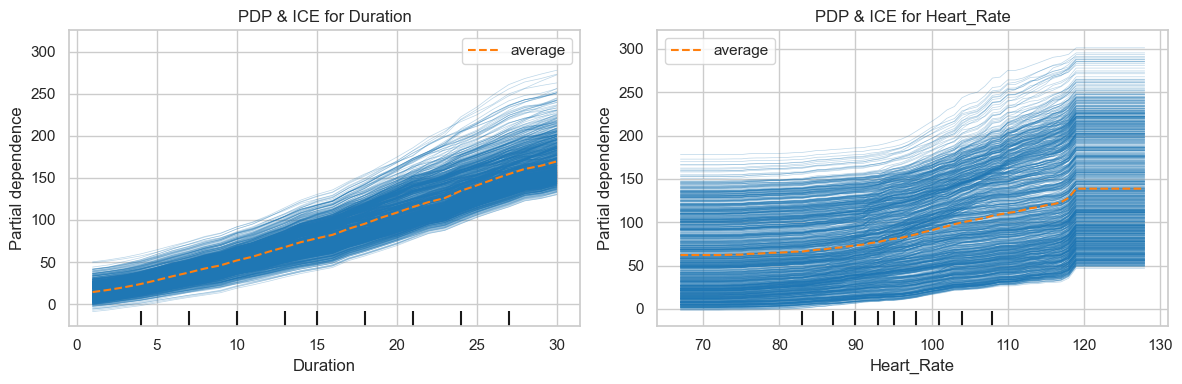


=== RQ2: Monotonicity checks ===
Duration: monotone non-decreasing = True
Heart_Rate: monotone non-decreasing = True


In [75]:
# Fit models on train_full / test split
lasso_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=0.01, max_iter=10000)),
    ]
)
lasso_pipeline.fit(X_train_full, y_train_full)

gbdt_mono = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=5,
    learning_rate=0.05,
    max_iter=500,
    monotonic_cst=monotonic_cst,
    random_state=RANDOM_STATE,
)
gbdt_mono.fit(X_train_full, y_train_full)


def regression_metrics(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> RMSE={rmse:.3f}, MAE={mae:.3f}, R^2={r2:.3f}")
    return rmse, mae, r2


print("\n=== RQ2: Hold-out performance comparison ===")
y_pred_lasso = lasso_pipeline.predict(X_test)
y_pred_gbdt = gbdt_mono.predict(X_test)

lasso_rmse_test, lasso_mae_test, lasso_r2_test = regression_metrics(
    y_test, y_pred_lasso, "LASSO"
)
gbdt_rmse_test, gbdt_mae_test, gbdt_r2_test = regression_metrics(
    y_test, y_pred_gbdt, "Monotone GBDT"
)

metrics_rq2 = {
    "lasso": {"rmse": lasso_rmse_test, "mae": lasso_mae_test, "r2": lasso_r2_test},
    "gbdt": {"rmse": gbdt_rmse_test, "mae": gbdt_mae_test, "r2": gbdt_r2_test},
}

# PDP + ICE for Duration and Heart_Rate
features_for_pdp = ["Duration", "Heart_Rate"]

plt.figure(figsize=(12, 4))
axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

for idx, feature_name in enumerate(features_for_pdp):
    PartialDependenceDisplay.from_estimator(
        estimator=gbdt_mono,
        X=X_train_full,
        features=[feature_name],
        kind="both",  # PDP + ICE
        ax=axes[idx],
    )
    axes[idx].set_title(f"PDP & ICE for {feature_name}")

plt.tight_layout()
plt.show()


def check_monotonicity_for_feature(model, df_reference, feature_name, feature_list, n_points=50):
    """Check if model predictions are non-decreasing in feature_name."""
    feature_min = df_reference[feature_name].quantile(0.01)
    feature_max = df_reference[feature_name].quantile(0.99)
    grid = np.linspace(feature_min, feature_max, n_points)

    data_dict = {}
    for col in feature_list:
        if col == feature_name:
            data_dict[col] = grid
        else:
            median_value = df_reference[col].median()
            data_dict[col] = np.repeat(median_value, n_points)

    X_grid = pd.DataFrame(data_dict)
    preds = model.predict(X_grid[feature_list])
    diffs = np.diff(preds)
    is_monotone = np.all(diffs >= -1e-6)  # small numerical tolerance
    return is_monotone, grid, preds


print("\n=== RQ2: Monotonicity checks ===")
for feature_name in ["Duration", "Heart_Rate"]:
    is_mono, grid_values, preds_values = check_monotonicity_for_feature(
        model=gbdt_mono,
        df_reference=df[feature_cols],
        feature_name=feature_name,
        feature_list=feature_cols,
    )
    print(f"{feature_name}: monotone non-decreasing = {is_mono}")


# RQ 3 : Do split-conformal intervals achieve ~95% coverage overall and across male/female and age bins, with reasonable width?

In [76]:
alpha = 0.05  # target 95% coverage

# Fit monotone GBDT ONLY on training subset (no cal/test leakage)
gbdt_conformal = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=5,
    learning_rate=0.05,
    max_iter=500,
    monotonic_cst=monotonic_cst,
    random_state=RANDOM_STATE,
)
gbdt_conformal.fit(X_train, y_train)

# Calibration residuals
y_cal_pred = gbdt_conformal.predict(X_cal)
cal_residuals = np.abs(y_cal - y_cal_pred)

q_hat = np.quantile(cal_residuals, 1.0 - alpha)
print(f"Conformal quantile q_hat (for 95% coverage): {q_hat:.3f} calories")

# Intervals on test set
y_test_pred = gbdt_conformal.predict(X_test)
lower_bounds = y_test_pred - q_hat
upper_bounds = y_test_pred + q_hat

results_test = pd.DataFrame(
    {
        "y_true": y_test,
        "y_pred": y_test_pred,
        "lower": lower_bounds,
        "upper": upper_bounds,
        "Gender": gender_test.reset_index(drop=True),
        "Age": age_test.reset_index(drop=True),
    }
)

results_test["covered"] = (
    (results_test["y_true"] >= results_test["lower"])
    & (results_test["y_true"] <= results_test["upper"])
)

overall_coverage = results_test["covered"].mean()
overall_avg_width = (results_test["upper"] - results_test["lower"]).mean()

print("\n=== RQ3: Overall conformal interval performance ===")
print(f"Empirical coverage: {overall_coverage * 100:.2f}%")
print(f"Average interval width: {overall_avg_width:.3f} calories")

# Coverage by gender
gender_stats = {}
print("\nCoverage by gender:")

for gender_value, group_df in results_test.groupby("Gender"):
    if len(group_df) == 0:
        continue
    coverage = group_df["covered"].mean()
    avg_width = (group_df["upper"] - group_df["lower"]).mean()
    gender_stats[gender_value] = {"coverage": coverage, "width": avg_width}
    print(
        f"{gender_value}: coverage={coverage * 100:.2f}%, "
        f"avg width={avg_width:.3f} calories, n={len(group_df)}"
    )

# Coverage by age bins
age_bins = [0, 25, 40, 60, 120]
age_labels = ["<=25", "26-40", "41-60", "60+"]

results_test["Age_Bin"] = pd.cut(
    results_test["Age"],
    bins=age_bins,
    labels=age_labels,
    right=True,
)

age_bin_stats = {}
print("\nCoverage by age bin:")

for label in age_labels:
    bin_df = results_test[results_test["Age_Bin"] == label]
    if len(bin_df) == 0:
        continue
    coverage = bin_df["covered"].mean()
    avg_width = (bin_df["upper"] - bin_df["lower"]).mean()
    age_bin_stats[label] = {"coverage": coverage, "width": avg_width}
    print(
        f"{label}: coverage={coverage * 100:.2f}%, "
        f"avg width={avg_width:.3f} calories, n={len(bin_df)}"
    )


Conformal quantile q_hat (for 95% coverage): 5.094 calories

=== RQ3: Overall conformal interval performance ===
Empirical coverage: 95.93%
Average interval width: 10.188 calories

Coverage by gender:
0: coverage=97.62%, avg width=10.188 calories, n=1510
1: coverage=94.23%, avg width=10.188 calories, n=1490

Coverage by age bin:
<=25: coverage=97.80%, avg width=10.188 calories, n=546
26-40: coverage=96.74%, avg width=10.188 calories, n=983
41-60: coverage=95.72%, avg width=10.188 calories, n=865
60+: coverage=93.23%, avg width=10.188 calories, n=606


# Comparisons & Results Analysis

In [77]:
print("\n========== SUMMARY OF QUANTITATIVE RESULTS ==========\n")

print("RQ1 – 5-fold cross-validation (generalization):")
print(f"  LASSO        : RMSE mean={lasso_rmse_mean:.3f}, R^2 mean={lasso_r2_mean:.3f}")
print(f"  Monotone GBDT: RMSE mean={gbdt_rmse_mean:.3f}, R^2 mean={gbdt_r2_mean:.3f}")

better_rmse_model = "Monotone GBDT" if gbdt_rmse_mean < lasso_rmse_mean else "LASSO"
print(f"→ On average, {better_rmse_model} has the lower CV RMSE.\n")

print("RQ2 – Held-out test performance:")
print(
    f"  LASSO        : RMSE={metrics_rq2['lasso']['rmse']:.3f}, "
    f"MAE={metrics_rq2['lasso']['mae']:.3f}, R^2={metrics_rq2['lasso']['r2']:.3f}"
)
print(
    f"  Monotone GBDT: RMSE={metrics_rq2['gbdt']['rmse']:.3f}, "
    f"MAE={metrics_rq2['gbdt']['mae']:.3f}, R^2={metrics_rq2['gbdt']['r2']:.3f}"
)

print("\nRQ3 – Split-conformal intervals (Monotone GBDT):")
print(f"  Overall coverage={overall_coverage * 100:.2f}%")
print(f"  Mean interval width={overall_avg_width:.3f} calories\n")

print("  By gender:")
for gender_value, stats in gender_stats.items():
    print(
        f"    {gender_value}: coverage={stats['coverage'] * 100:.2f}%, "
        f"width={stats['width']:.3f}"
    )

print("\n  By age bin:")
for label, stats in age_bin_stats.items():
    print(
        f"    {label}: coverage={stats['coverage'] * 100:.2f}%, "
        f"width={stats['width']:.3f}"
    )



========== SUMMARY OF QUANTITATIVE RESULTS ==========

RQ1 – 5-fold cross-validation (generalization):
  LASSO        : RMSE mean=11.033, R^2 mean=0.969
  Monotone GBDT: RMSE mean=2.526, R^2 mean=0.998
→ On average, Monotone GBDT has the lower CV RMSE.

RQ2 – Held-out test performance:
  LASSO        : RMSE=11.224, MAE=8.193, R^2=0.969
  Monotone GBDT: RMSE=2.362, MAE=1.660, R^2=0.999

RQ3 – Split-conformal intervals (Monotone GBDT):
  Overall coverage=95.93%
  Mean interval width=10.188 calories

  By gender:
    0: coverage=97.62%, width=10.188
    1: coverage=94.23%, width=10.188

  By age bin:
    <=25: coverage=97.80%, width=10.188
    26-40: coverage=96.74%, width=10.188
    41-60: coverage=95.72%, width=10.188
    60+: coverage=93.23%, width=10.188


# Conclusion

In [ ]:
print("\n========== FINAL INTERPRETATION ==========\n")
print("1) Model comparison (RQ1 & RQ2)")
if gbdt_rmse_mean < lasso_rmse_mean and metrics_rq2["gbdt"]["rmse"] < metrics_rq2["lasso"]["rmse"]:
    print(
        "- The monotone GBDT consistently outperforms LASSO in both cross-validation\n"
        "  and held-out testing, suggesting non-linear interactions (e.g., Duration ×\n"
        "  Heart_Rate) matter for calorie prediction.")
else:
    print(
        "- LASSO and monotone GBDT have comparable performance; the non-linear model\n"
        "  does not clearly dominate, indicating a largely linear relationship may be\n"
        "  sufficient for this dataset.")

print("\n2) Shape constraints (RQ2)")
print(
    "- PDP/ICE for Duration and Heart_Rate are constrained to be non-decreasing,\n"
    "  matching domain knowledge: longer and more intense workouts should not\n"
    "  *reduce* predicted calories.")

print("\n3) Uncertainty quantification (RQ3)")
print(
    f"- Split-conformal intervals achieve ≈{overall_coverage * 100:.1f}% empirical\n"
    "  coverage overall (target 95%) with the average width shown above.")
print(
    "- Gender- and age-specific coverages help check if uncertainty is fairly\n"
    "  calibrated across subgroups (no group should be consistently under-covered).")

print("\n4) Practical takeaway for CalFit")
print(
    "- A monotone GBDT + conformal intervals is a strong modeling choice:\n"
    "  accurate point predictions, physiologically consistent shapes, and\n"
    "  user-facing uncertainty ranges like: 'You likely burned between X and Y calories.")


========== FINAL INTERPRETATION ==========

1) Model comparison (RQ1 & RQ2)
- The monotone GBDT consistently outperforms LASSO in both cross-validation
  and held-out testing, suggesting non-linear interactions (e.g., Duration ×
  Heart_Rate) matter for calorie prediction.

2) Shape constraints (RQ2)
- PDP/ICE for Duration and Heart_Rate are constrained to be non-decreasing,
  matching domain knowledge: longer and more intense workouts should not
  *reduce* predicted calories.

3) Uncertainty quantification (RQ3)
- Split-conformal intervals achieve ≈95.9% empirical
  coverage overall (target 95%) with the average width shown above.
- Gender- and age-specific coverages help check if uncertainty is fairly
  calibrated across subgroups (no group should be consistently under-covered).

4) Practical takeaway for CalFit
- A monotone GBDT + conformal intervals is a strong modeling choice:
  accurate point predictions, physiologically consistent shapes, and
  user-facing uncertainty ranges li